In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

C:\Users\jiaha\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [3]:
class MaskDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(32, 20, kernel_size=(2, 2), stride=(2, 2))
        )

    def forward(self, img_embed):
        """ img_embed: (B, 256, 64, 64)
            @returns (B, C, 1024, 1024) logits
        """
        return self.layers(img_embed)

class SamLinear(nn.Module):
    def __init__(self, sam, C=20):
        super().__init__()
        self.sam = sam
        self.decoder = MaskDecoder()
        self.C = C
    
    def forward(self, img):
        """ img: (B, 3, 1024, 1024)
            @returns (B, C, 1024, 1024) logits
        """
        # (B, 256, 64, 64)
        with torch.no_grad():
            img_embed = self.sam.image_encoder(img)
        # (B, C, 1024, 1024)
        masks = self.decoder(img_embed)
        return masks

model = SamLinear(sam)
model = model.to(device)

In [4]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from segment_anything.utils.transforms import ResizeLongestSide

class PeoplePosesDataset(Dataset):
    def __init__(self, device, mode="train", img_size=1024):
        assert mode in ("train", "val")
        self.mode = mode
        self.root = "../datasets/people_poses"
        self.image_dir = os.path.join(self.root, f"{self.mode}_images")
        self.mask_dir = os.path.join(self.root, f"{self.mode}_segmentations")
        with open(os.path.join(self.root, f"{self.mode}_id.txt"), 'r') as lf:
            self.data_list = [ s.strip() for s in lf.readlines() ]
        self.img_size = img_size
        self.transform = ResizeLongestSide(img_size)
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def preprocess(self, x):
        # TODO(jiahang): clean up this dependency issue
        x = (x - model.sam.pixel_mean) / model.sam.pixel_std

        h, w = x.shape[-2:]
        padh = self.img_size - h
        padw = self.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.image_dir, self.data_list[index] + ".jpg"))
        label = cv2.imread(os.path.join(self.mask_dir, self.data_list[index] + ".png"))
        image = self.transform.apply_image(image[..., ::-1])
        H, W, C = image.shape
        image = torch.as_tensor(image, device=self.device)
        image = image.permute(2, 0, 1).contiguous()[None, :, :, :]
        image = self.preprocess(image)

        label = torch.as_tensor(label, device=self.device)
        label = label.permute(2, 0, 1).contiguous()[None, :, :, :]
        label = F.interpolate(label, (H, W), mode='nearest')
        label = label.to(torch.int64)
        label = F.pad(label, (0, self.img_size - W, 0, self.img_size - H), value=-1)

        # torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
        return image[0], label[0][0]

"""
x, y = next(iter(dataloader))
x.shape, y.shape, x.dtype, y.dtype
(torch.Size([8, 3, 1024, 1024]),
 torch.Size([8, 1024, 1024]),
 torch.float32,
 torch.int8)
"""
dataset = PeoplePosesDataset(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
from tqdm import tqdm

def loss_fn(logits, labels):
    """ logits/labels: (B, C, 1024, 1024) """
    return F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')

def train_one_epoch(epoch_index):
    for data in (pbar := tqdm(dataloader)):
        images, labels = data
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'loss: {loss}')

optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-3)
for epoch in range(20):
    print('EPOCH {}:'.format(epoch))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    train_one_epoch(epoch)

    model_path = 'model_{}'.format(epoch)
    torch.save(model.state_dict(), model_path)

EPOCH 0:


loss: 0.8036062121391296:  60%|████████████████████████████████████████████████▉                                | 18397/30462 [8:01:26<5:15:43,  1.57s/it]


KeyboardInterrupt: 

In [6]:
model_path = 'model_half'.format(epoch)
torch.save(model.state_dict(), model_path)

In [9]:
val_dataset = PeoplePosesDataset(device, mode="val")
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [11]:
x, y = next(iter(val_dataloader))
x.shape, y.shape

(torch.Size([1, 3, 1024, 1024]), torch.Size([1, 1024, 1024]))

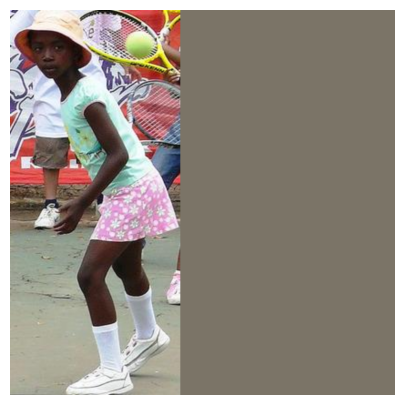

In [16]:
image = x * model.sam.pixel_std + model.sam.pixel_mean
image = torch.permute(image[0], [1, 2, 0]).cpu().numpy().astype(np.uint8)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

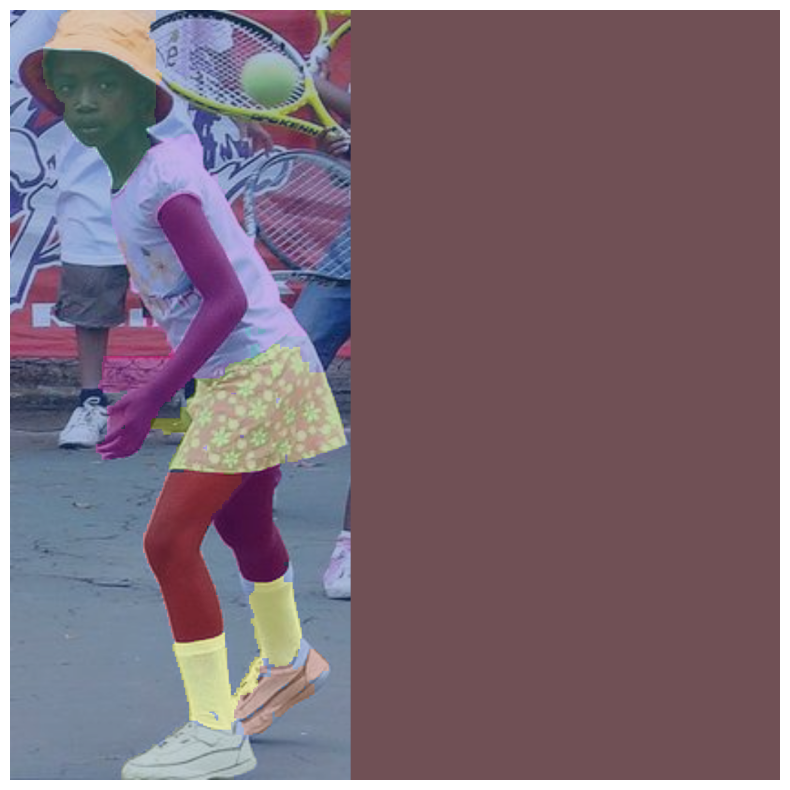

In [20]:
def gt_to_anns(mask_gt):
    labels = np.unique(mask_gt)
    anns = []
    for label in labels:
        mask = np.all(mask_gt == label, axis=-1)
        anns.append({
            'area': np.sum(mask),
            'segmentation': mask,
            'label': label
        })
    return anns

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

label = torch.permute(y, [1, 2, 0]).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(gt_to_anns(label))
plt.axis('off')
plt.show() 

In [24]:
with torch.no_grad():
    model.eval()
    logit = model(x)
    logit.shape

In [26]:
pred = logit.cpu().numpy().argmax(axis=1)
pred.shape

(1, 1024, 1024)

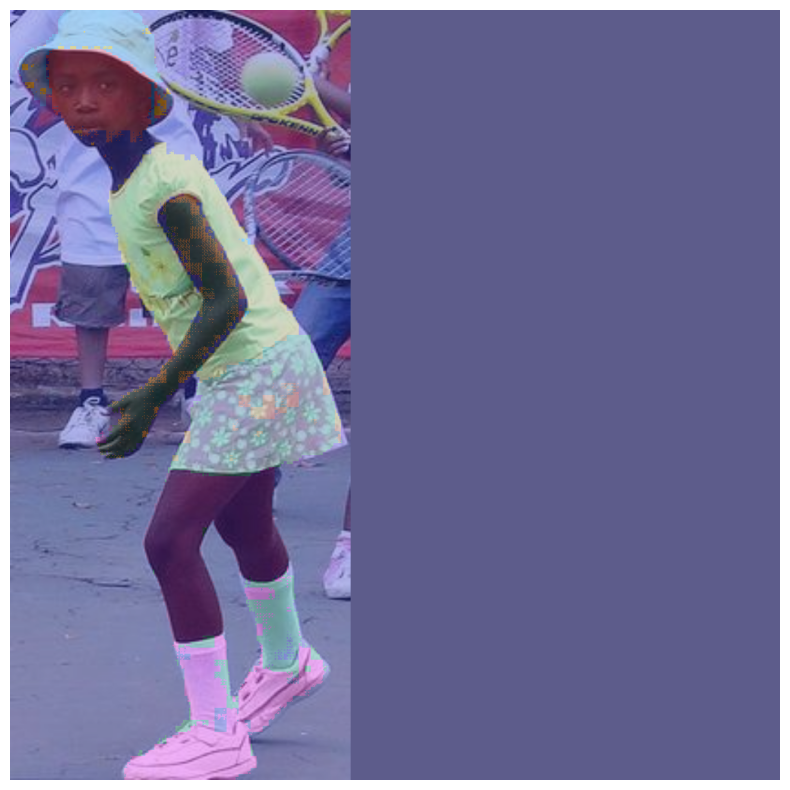

In [28]:
pred = np.transpose(pred, [1, 2, 0])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(gt_to_anns(pred))
plt.axis('off')
plt.show() 

In [32]:
(pred == label).mean()

0.3402872085571289

In [36]:
import pandas as pd

In [38]:
label_txt = """Background
Hat
Hair
Glove
Sunglasses
UpperClothes
Dress
Coat
Socks
Pants
Jumpsuits
Scarf
Skirt
Face
Left-arm
Right-arm
Left-leg
Right-leg
Left-shoe
Right-shoe"""
label_txt = label_txt.split('\n')
label_txt

['Background',
 'Hat',
 'Hair',
 'Glove',
 'Sunglasses',
 'UpperClothes',
 'Dress',
 'Coat',
 'Socks',
 'Pants',
 'Jumpsuits',
 'Scarf',
 'Skirt',
 'Face',
 'Left-arm',
 'Right-arm',
 'Left-leg',
 'Right-leg',
 'Left-shoe',
 'Right-shoe']

In [39]:
ious = []
pixels = []
for i in range(20):
    label_i = (label == i)
    pred_i = (pred == i)
    ious.append((label_i & pred_i).sum() / ((label_i | pred_i).sum() + 1e-6))
    pixels.append(label_i.sum())
print(np.mean(ious))
pd.DataFrame({ 'labels': label_txt, 'ious': ious, 'pixels': pixels })

0.1476103356045268


,labels,ious,pixels
0,Background,0.317702,292908
1,Hat,0.022547,8425
2,Hair,0.000000,0
3,Glove,0.000000,0
4,Sunglasses,0.000000,0
5,UpperClothes,0.794563,32816
6,Dress,0.000000,28561
7,Coat,0.000000,0
8,Socks,0.000000,14528
9,Pants,0.000000,0
